In [1]:
import matplotlib
# %matplotlib inline
# print("BACKEND: ", matplotlib.get_backend())
# if matplotlib.get_backend() != "macosx":
#   print("Changing backend to macosx")
#   matplotlib.use('macosx')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.visualize import view

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np

/home/ntt203/.conda/envs/raffle_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-04 13:58:13,427	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [4]:
from agox.models.descriptors.fingerprint import Fingerprint
# from agox.models.descriptors import Voronoi

template = Atoms("", cell=np.eye(3) * 3.567, pbc=True)
diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="C8",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
# graph_descriptor = Voronoi(
#     covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=environment
# )


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│     C = 8                                                                    │
│ Template formula:                                                            │
│ Full formula: C8                                                             │
│ Cell:                                                                        │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     3.57 0.00 0.00                                                           │
│     0.00 3.57 0.00                                                           │
│     0.00 0.00 3.57                                                           │
╰──────────────────────────────────────────────────────────────────────────────╯

In [5]:
from chgnet.model import CHGNetCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [6]:
# graph_sorting = Analysis(descriptor=graph_descriptor, directories=["."], sample_size=1000)

In [7]:
seed = 0
identifier = ""
min_energy = -9.064090728759766

In [8]:
unrlxd_structures = read("DTMP"+identifier+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures:
  structure.calc = calc

In [9]:
rlxd_structures = read("DTMP"+identifier+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures:
  structure.calc = calc

In [10]:
# unique, count = graph_sorting.sort_structures(structures=structures)
# print("Repeats of unique structures: ", count)

In [11]:
# Calculate energies per atom for each unique structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unrlxd_structures]
unrlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Unrelaxed min energy: ", np.min(energies_per_atom))

Unrelaxed min energy:  -6.4840655


In [12]:
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in rlxd_structures]
rlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Relaxed min energy: ", np.min(energies_per_atom))

Relaxed min energy:  -9.06409


In [13]:
if abs( np.min(energies_per_atom) - min_energy ) > 5e-2:
  print("Minimum energy per atom is not zero. Check the energy calculation.")
  # exit()

In [14]:
# # further reduce the delta_en_per_atom and count by the bin width
# delta_en_per_atom_rounded = np.round(delta_en_per_atom / bin_width) * bin_width
# delta_en_per_atom_binned = np.unique(delta_en_per_atom_rounded)
# count_binned = np.zeros_like(delta_en_per_atom_binned)
# for i, de in enumerate(delta_en_per_atom_binned):
#   for j, de2 in enumerate(delta_en_per_atom_rounded):
#     if abs(de - de2) < 1e-4:
#       count_binned[i] += count[j]

In [15]:
# # Plot the number of unique structures vs the energies per atom
# plt.figure(figsize=(10, 6))
# plt.bar(delta_en_per_atom_binned, count_binned, width=0.1)
# plt.xlabel('Energy per Atom (eV/atom)')
# plt.ylabel('Number of structures')
# plt.title('Number of Unique Structures vs Energies per Atom ('+rlxd_string+' seed '+str(seed)+')')
# # plt.show()
# plt.savefig("RSS_unique_structures_vs_energies_per_atom_"+rlxd_string+"_seed"+str(seed)+".png")

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)

In [23]:
rlxd_string = "rlxd" # which dataset to fit the PCA model to

In [24]:
# save pca model
import pickle
if False:
  pca.fit(np.squeeze([arr for arr in descriptor.get_features(unrlxd_structures)]))
  with open("pca_model"+identifier+"_all_unrlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

# load pca model
with open("../DRAFFLE/pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [25]:
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(unrlxd_structures)]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(rlxd_structures)]))

In [26]:
min_energy_index = np.argmin(rlxd_delta_en_per_atom)
print(min_energy_index)

463


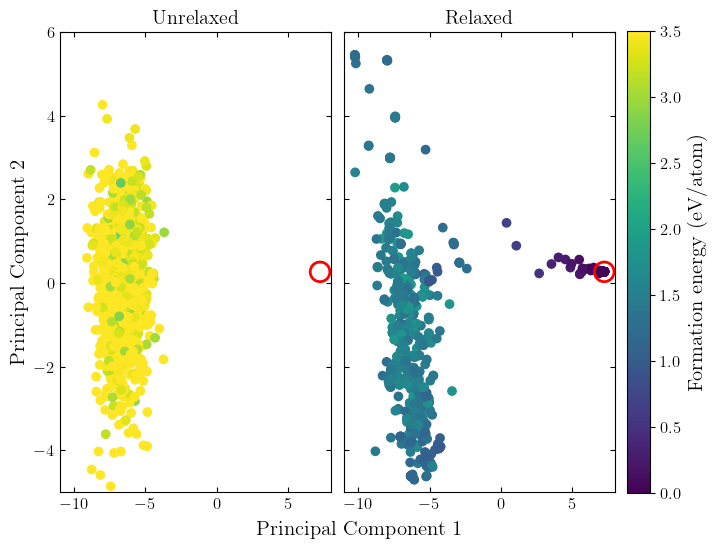

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

max_en = min(3.5, max(np.max(unrlxd_delta_en_per_atom), np.max(rlxd_delta_en_per_atom)))

axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=unrlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=rlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
for ax in axes:
  ax.scatter(rlxd_X_reduced[min_energy_index, 0], rlxd_X_reduced[min_energy_index, 1], s=200, edgecolor='red', facecolor='none', linewidth=2)

fig.text(0.5, 0.04, 'Principal Component 1', ha='center', fontsize=15)
axes[0].set_ylabel('Principal Component 2', fontsize=15)
axes[0].set_title('Unrelaxed')
axes[1].set_title('Relaxed')
if identifier == "_VASP":
  if rlxd_string == "rlxd":
    xlims = [-11, 8]
    ylims = [-5, 6]
  else:
    xlims = [-9, 13]
    ylims = [-7, 12]
else:
  if rlxd_string == "rlxd":
    xlims = [-11, 8]
    ylims = [-5, 6]
  else:
    xlims = [-5, 13]
    ylims = [-6.5, 13]

for ax in axes:
  ax.tick_params(axis='both', direction='in')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

# unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]

axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

# Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

# Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.set_label('Formation energy (eV/atom)', fontsize=15)

plt.savefig('C_RSS'+identifier+'_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')